In [1]:
import numpy as np
import pandas as pd
from astropy import units as u, constants as con
import matplotlib.pyplot as plt
from itertools import combinations

# %matplotlib ipympl

In [2]:
df = pd.read_csv('./meerkat.csv', delimiter='\t')
df

,Antenna,East,North,Up
0,m000,-8.264,-207.290,8.597
1,m001,1.121,-171.762,8.471
2,m002,-32.113,-224.236,8.645
3,m003,-66.518,-202.276,8.285
4,m004,-123.624,-252.946,8.513
...,...,...,...,...
59,m059,3686.427,758.895,11.822
60,m060,3419.683,-1840.478,23.697
61,m061,-16.409,-2323.779,21.304
62,m062,-1440.632,-2503.773,21.683


In [3]:
n_antennas = len(df)
pairs = list(combinations(range(n_antennas), 2))
n_baselines = len(pairs)
print(n_baselines, n_antennas * (n_antennas - 1) // 2)

2016 2016


In [4]:
baselines = np.empty((n_baselines, 3))
for i, (ant1, ant2) in enumerate(pairs):
    baselines[i] = df.iloc[ant1][['East', 'North', 'Up']].values - df.iloc[ant2][['East', 'North', 'Up']].values

baselines = baselines * u.m

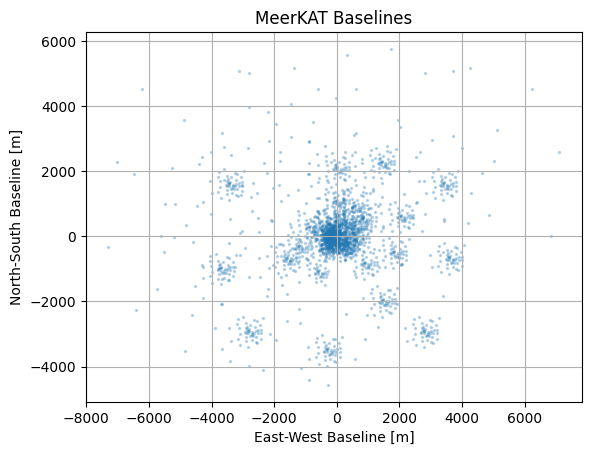

In [18]:
plt.figure()
plt.scatter(baselines[:, 0].to(u.m).value, baselines[:, 1].to(u.m).value, s=2, alpha=0.25)
plt.grid()
plt.xlabel('East-West Baseline [m]')
plt.ylabel('North-South Baseline [m]')
plt.title('MeerKAT Baselines')
plt.show()
plt.close()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_15991/4074527640.py:11: RuntimeWarning: divide by zero encountered in log10
  cp = plt.contourf(Xc, Yc, np.log10(H.T), levels=20, cmap='viridis')


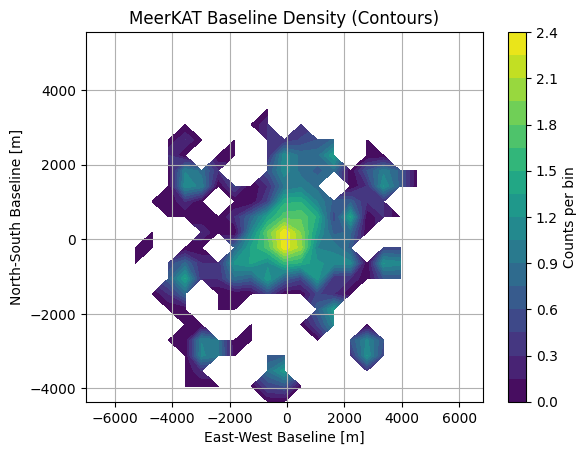

In [16]:
# 2D histogram and contour plot of baseline density
x = baselines[:, 0].to(u.m).value
y = baselines[:, 1].to(u.m).value

# Create 2D histogram
nbins = 25
H, xedges, yedges = np.histogram2d(x, y, bins=nbins)
Xc, Yc = np.meshgrid(0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1]))

plt.figure()
cp = plt.contourf(Xc, Yc, np.log10(H.T), levels=20, cmap='viridis')
plt.colorbar(cp, label='Counts per bin')
plt.xlabel('East-West Baseline [m]')
plt.ylabel('North-South Baseline [m]')
plt.title('MeerKAT Baseline Density (Contours)')
plt.grid()
plt.show()
plt.close()

In [45]:
# bin by magnitude
basemags = np.sqrt(baselines[:, 0]**2 + baselines[:, 1]**2 + baselines[:, 2]**2).to(u.m).value

nbins = 25
logbl_bins = np.logspace(np.log10(basemags.min()), np.log10(basemags.max()), nbins)
linbl_bins = np.linspace(basemags.min(), basemags.max(), nbins)
logbl_cens = 0.5 * (logbl_bins[1:] + logbl_bins[:-1])
linbl_cens = 0.5 * (linbl_bins[1:] + linbl_bins[:-1])

logbinned_bl = np.histogram(basemags, bins=logbl_bins)[0]
linbinned_bl = np.histogram(basemags, bins=linbl_bins)[0]

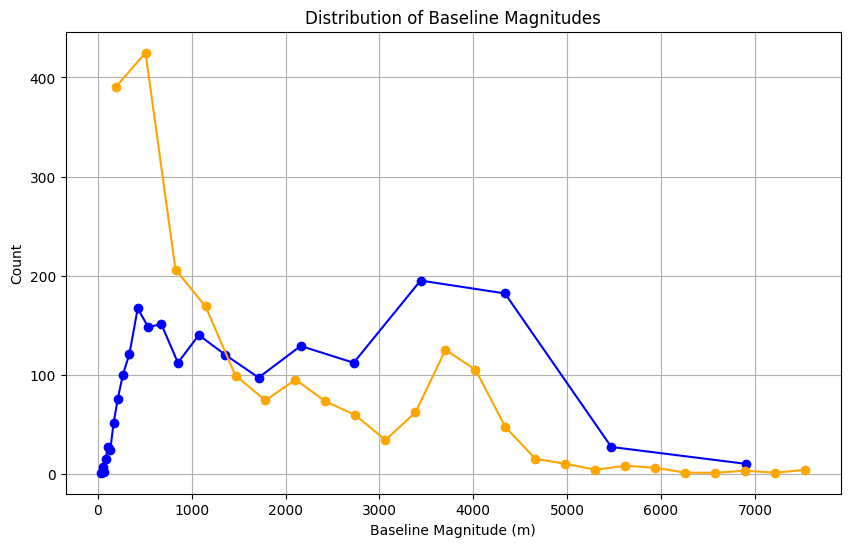

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(logbl_cens, logbinned_bl, marker='o', label='Log Binned', color='blue')
plt.plot(linbl_cens, linbinned_bl, marker='o', label='Linear Binned', color='orange')
# plt.xscale('log')
plt.xlabel('Baseline Magnitude (m)')
plt.ylabel('Count')
plt.title('Distribution of Baseline Magnitudes')
plt.grid()
plt.show()

In [ ]:
from astropy.cosmology import Planck18 as cosmo

Z_FOR_MODELLING = 1.0
lamb21hi = 21 * u.cm
kperps = basemags * u.m * 2 * np.pi / lamb21hi / cosmo.comoving_transverse_distance(Z_FOR_MODELLING)
kperps = kperps.to(1/u.Mpc).value

array([ 0.32378749,  0.25778778,  0.51519819, ..., 12.64906795,
       30.28728502, 18.3905862 ])

In [50]:
# bin by magnitude
nbins = 25
logkperps_bins = np.logspace(np.log10(kperps.min()), np.log10(kperps.max()), nbins)
linkperps_bins = np.linspace(kperps.min(), kperps.max(), nbins)
logkperps_cens = 0.5 * (logkperps_bins[1:] + logkperps_bins[:-1])
linkperps_cens = 0.5 * (linkperps_bins[1:] + linkperps_bins[:-1])

logbinned_kperps = np.histogram(kperps, bins=logkperps_bins)[0]
linbinned_kperps = np.histogram(kperps, bins=linkperps_bins)[0]

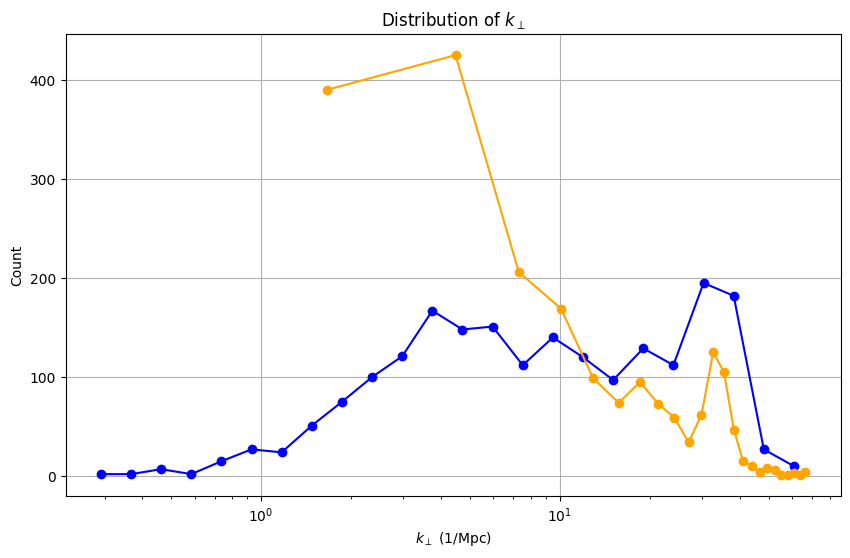

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(logkperps_cens, logbinned_kperps, marker='o', label='Log Binned', color='blue')
plt.plot(linkperps_cens, linbinned_kperps, marker='o', label='Linear Binned', color='orange')
plt.xscale('log')
plt.xlabel(r'$k_\perp$ (1/Mpc)')
plt.ylabel('Count')
plt.title('Distribution of $k_\perp$')
plt.grid()
plt.show()